In [ ]:
import pandas as pd
from common import collect_results, normalize_region_name, compute_quantiles
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
ROOT = Path("tpcc")

def get_matcher(system):
    def matcher(p: Path):   
        import re
        pattern = re.compile(r"tpcc-\d+-%s-terminals\d+-([\d-]+)" % system)
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        return {
            "suffix": str(match.group(1)),
        }
    
    return matcher

In [ ]:
import json

def yb_matcher(p: Path):   
    import re
    pattern = re.compile(r"tpcc-(\d+)-yugabyte-terminals(\d+)")
    match = pattern.match(p.name)
    if not match:
        return None

    print("Found result:", p.name)
    return {
        "scalefactor": int(match.group(1)),
        "terminals": int(match.group(2)),
    }

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def collect_yugabyte_results(path, renew_cache: bool):
    cache = path / "cache.csv"

    if renew_cache:
        cache.unlink(missing_ok=True)

    if cache.is_file():
        return pd.read_csv(cache)

    records = []
    for result_dir in path.iterdir():
        if not result_dir.is_dir():
            continue

        metadata = yb_matcher(result_dir)
        if metadata is None:
            continue

        for region_path in result_dir.iterdir():
            if not region_path.is_dir():
                continue
            record = {"path": region_path.as_posix(), "region": region_path.name, **metadata}

            raw_df = pd.read_csv(region_path / "oltpbench.csv", skiprows=2)
            raw_df["OperationLatency (microseconds)"] /= 1000

            transactions = raw_df["Transaction Name"].unique()
            for transaction in transactions:
                record.update(
                    compute_quantiles(
                        raw_df[raw_df["Transaction Name"] == transaction]["OperationLatency (microseconds)"],
                        remove_upper_outliers=True,
                        suffix=f".{transaction}"
                    )
                )

            record.update(
                compute_quantiles(
                    raw_df["OperationLatency (microseconds)"],
                    remove_upper_outliers=True
                )
            )

            output = json.loads((region_path / "json" / "output.json").read_text())

            runtime = output["TestConfiguration"]["runTimeInSecs"]
            record["time"] = runtime
            record["warmup"] = output["TestConfiguration"]["warmupTimeInSecs"]
            record["throughput"] = output["Results"]["throughput"]
            for lat in output["Latencies"]:
                if lat["Transaction"] != "All":
                    record[f"throughput.{lat['Transaction']}"] = lat["Count"] / runtime

            records.append(record)
    
    df = pd.DataFrame.from_records(records)
    df.to_csv(cache, index=False)

    return df

# Throughput


In [ ]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"
sunstorm_throughput_df["terminals_rank"] = sunstorm_throughput_df["terminals"].rank(method="dense")
normalize_region_name(sunstorm_throughput_df)

aurora_matcher = get_matcher("aurora")
aurora_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_throughput_df["system"] = "aurora"
aurora_throughput_df["terminals_rank"] = aurora_throughput_df["terminals"].rank(method="dense")
normalize_region_name(aurora_throughput_df)

yugabyte_matcher = get_matcher("yugabyte")
yugabyte_throughput_df = collect_yugabyte_results(ROOT / "yugabyte", RENEW_CACHE)
yugabyte_throughput_df["system"] = "yugabyte"
yugabyte_throughput_df["terminals_rank"] = yugabyte_throughput_df["terminals"].rank(method="dense")
normalize_region_name(yugabyte_throughput_df)

In [ ]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_throughput_df,
    yugabyte_throughput_df,
])
throughput_df

## Scalefactor


In [ ]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values="throughput", aggfunc="sum"
)

## Throughput vs. Latency

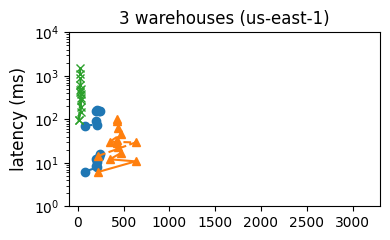

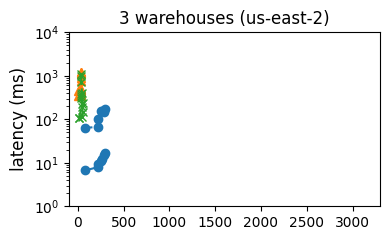

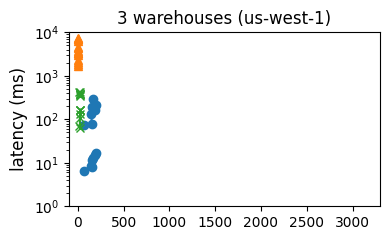

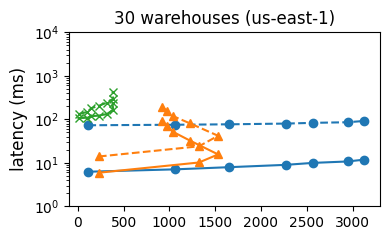

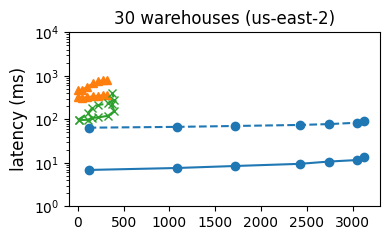

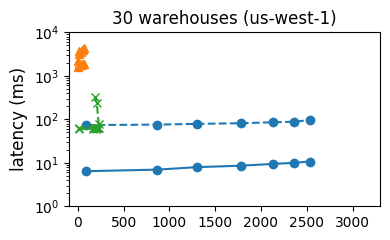

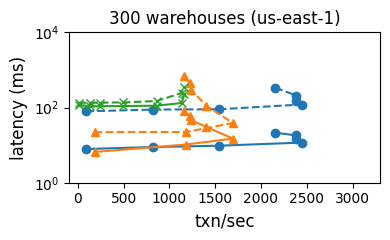

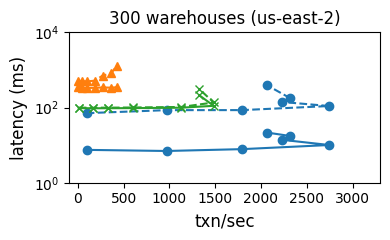

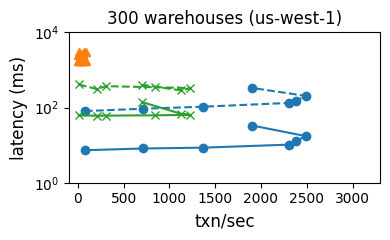

In [30]:
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for scalefactor in [1, 10, 100]:
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for region in ["1-us-east-1-0", "2-us-east-2-0", "3-us-west-1-0"]:
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-us-east-2-0": "us-east-2",
            "3-us-west-1-0": "us-west-1",
        }[region]

        fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p99.NewOrder", "--")]:         
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    y=y,           
                    xlabel="",        
                    ylabel=f"latency (ms)",
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    # logx=True,
                    xlim=(-100, 3300),
                    ax=ax,
                    legend=False,
                )

        if scalefactor == 100:
            ax.set_xlabel("txn/sec")
        ax.set_ylim(bottom=1, top=10000)
        fig.tight_layout()
        fig.savefig(f"output/tpcc-wh{scalefactor}-{region_name}.pdf", bbox_inches="tight")

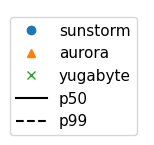

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(0.1, 0.1)) 
ax.set_axis_off() 
ax.legend(handles=[
    Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
    Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
    Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
    Line2D([0], [0], color='k', linestyle='-', label='p50'),
    Line2D([0], [0], color='k', linestyle='--', label='p99'),
], ncol=1) 
fig.savefig("output/tpcc-legend.pdf", bbox_inches="tight")

In [ ]:
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for scalefactor in [1, 10, 100]:
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for region in ["1-us-east-1-0", "2-us-east-2-0", "3-us-west-1-0"]:
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-us-east-2-0": "us-east-2",
            "3-us-west-1-0": "us-west-1",
        }[region]

        fig, ax = plt.subplots(1, 1, figsize=(5, 3.2))

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p95.NewOrder", "--")]:               
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    xlabel="txn/sec",
                    y=y,                   
                    ylabel=f"latency (ms)",
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    logx=True,
                    # xlim=(-100, 3300),
                    ax=ax,
                )

        ax.set_ylim(bottom=0.4)
        ax.legend(
            handles=[
                Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
                Line2D([0], [0], color='k', linestyle='-', label='p50'),
                Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
                Line2D([0], [0], color='k', linestyle='--', label='p99'),
                Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
            ], 
            title="",
            ncol=3,
            loc="lower center",
            handletextpad=0.3,
        )
        fig.tight_layout()
        fig.savefig(f"output/tpcc-wh{scalefactor}-{region_name}-logx.pdf", bbox_inches="tight")

# Errors


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3.5), sharex=True, sharey=True)

for i, scalefactor in enumerate([1, 10, 100]):
    filtered = throughput_df[
        throughput_df["scalefactor"] == scalefactor
    ].sort_values("terminals_rank")
    rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values="rejected", aggfunc="sum")
    completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values="completed", aggfunc="sum")
    ratio_df = rejected_df / (rejected_df + completed_df) * 100
    ratio_df.plot.bar(
        title=f"TPC-C Rejected (scalefactor={scalefactor})",
        xlabel="terminals rank",
        ylabel="abort %",
        ax=axes[i],
        rot=0,
    )

fig.tight_layout()


In [ ]:
transactions = ["NewOrder", "Payment", "OrderStatus", "Delivery", "StockLevel"]
fig, axes = plt.subplots(len(transactions), 3, figsize=(16, 16), sharex=True, sharey=True)

for row, transaction in enumerate(transactions):
    for col, scalefactor in enumerate([1, 10, 100]):
        filtered = throughput_df[
            throughput_df["scalefactor"] == scalefactor
        ].sort_values("terminals_rank")
        rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"rejected.{transaction}", aggfunc="sum")
        completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"completed.{transaction}", aggfunc="sum")
        ratio_df = rejected_df / (rejected_df + completed_df) * 100
        ratio_df.plot.bar(
            title=f"{transaction} (scalefactor={scalefactor})",
            xlabel="terminals rank",
            ylabel="abort %",
            ax=axes[row, col],
            rot=0,
        )

fig.tight_layout()
